<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/06_aipi590_xai_explainableAI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# AIPI 590 - XAI | Assignment 06

#Description: Explainable AI Part 2

This notebook is for exploring explainable AI methods such as PDP, ICE, and ALE plots. We are using the breast cancer dataset for the exploration.

## Chad Miller

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/06_aipi590_xai_explainableAI2.ipynb)

In [1]:

import os

# Remove Colab default sample_data
!rm -r /content/sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590-XAI"
git_path = 'https://github.com/mille055/AIPI590-XAI.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"


notebook_dir = 'Assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)


Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 373 (delta 122), reused 0 (delta 0), pack-reused 191 (from 1)
Receiving objects: 100% (373/373), 56.33 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (238/238), done.
  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-install-xoec276d/rulefit_e15951b021664ff9b1b172aaaa09b91f
  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulefit.git /tmp/pip-install-xoec276d/rulefit_e15951b021664ff9b1b172aaaa09b91f
  Resolved https://github.com/christophM/rulefit.git to commit 472b8574b4eb9e565caf1e05ed580998fe2c9a8e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
## Standard libraries
import json
import math
import time
import numpy as np
import tabulate
import urllib.request
import zipfile
import pandas as pd

## Imports for data exploration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Imports for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


## Imports for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Imports for imodels assignment
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, export_text

## Imports for XGBoost model
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

## Imports for GAM
from pygam import LogisticGAM, LinearGAM, GammaGAM, s

## Imports for explainable ai
import alibi
from alibi.explainers import AnchorImage
from alibi.explainers import ALE
from skimage.transform import resize
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import pdpbox
import warnings
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

## Imports for plotting
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet



In [4]:
# get the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Download Datasets and EDA

In [5]:
# Downloading dataset
data = load_breast_cancer(as_frame=True)
df = data.frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Shape: (569, 31)
Columns: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']
Missing Values: 0
Data Types: {dtype('float64'): 30, dtype('int64'): 1}
Unique Values: {'mean radius': 456, 'mean texture': 479, 'mean perimeter': 522, 'mean area': 539, 'mean smoothness': 474, 'mean compactness': 537, 'mean concavity': 537, 'mean concave points': 542, 'mean symmetry': 432, 'mean fractal dimension': 499, 'radius error': 540, 'texture error': 519, 'perimeter error': 533

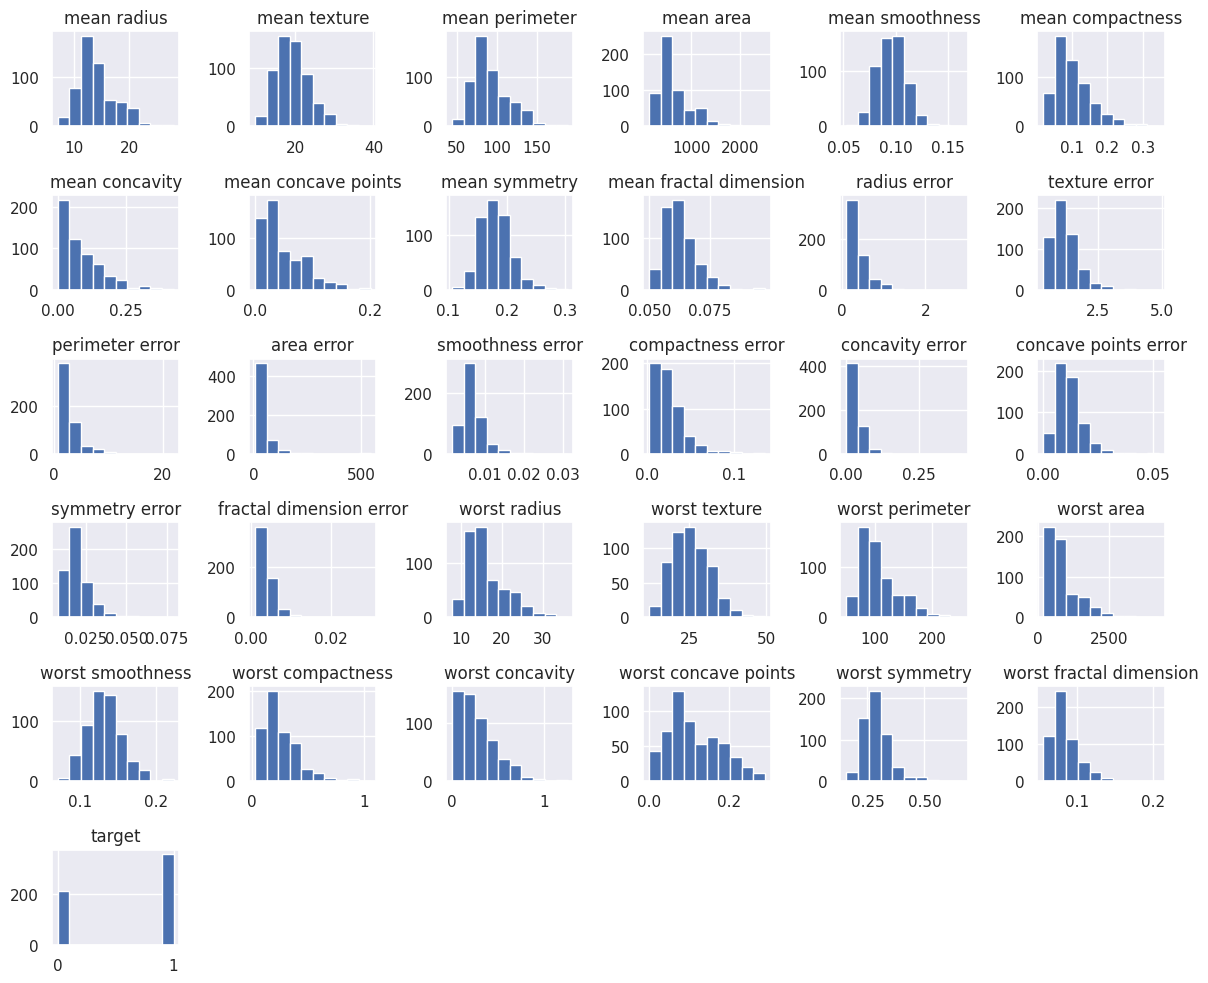

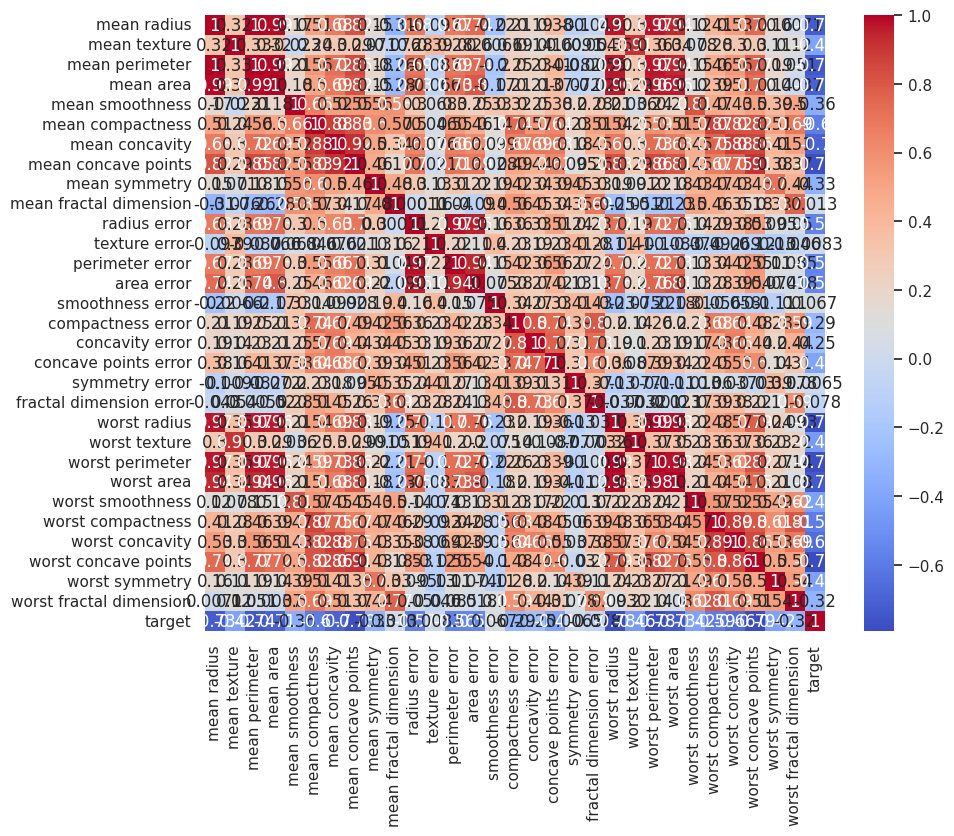


Colinearity Check:

                    Feature          VIF
0                     const  2041.278511
1               mean radius  3817.259795
2              mean texture    11.891280
3            mean perimeter  3792.697001
4                 mean area   348.115385
5           mean smoothness     8.194309
6          mean compactness    51.445960
7            mean concavity    71.002747
8       mean concave points    60.172431
9             mean symmetry     4.220806
10   mean fractal dimension    15.756978
11             radius error    75.737325
12            texture error     4.205686
13          perimeter error    70.398925
14               area error    41.196467
15         smoothness error     4.070801
16        compactness error    15.366350
17          concavity error    15.914022
18     concave points error    11.601253
19           symmetry error     5.179151
20  fractal dimension error     9.724753
21             worst radius   815.945630
22            worst texture    18.60

In [6]:

# Check multicollinearity using Variance Inflation Factor (VIF)
def check_multicollinearity(df):
  X = df.select_dtypes(include=[float, int])  # Select only numeric features

  # Add constant for the intercept term
  X = sm.add_constant(X)

  # Calculate VIF
  vif_data = pd.DataFrame()
  vif_data['Feature'] = X.columns
  vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  print(vif_data)


def EDA(df):
  df1= df.copy()

  # Display basic information about the dataset
  dataset_info = {
    'Shape': df1.shape,
    'Columns': df1.columns.tolist(),
    'Missing Values': df1.isnull().sum().sum(),
    'Data Types': df1.dtypes.value_counts().to_dict(),
    'Unique Values': df1.nunique().to_dict()
  }

  for key, value in dataset_info.items():
    print(f"{key}: {value}")


  print(df1.head())

  # Summary statistics
  summary_statistics = df1.describe()
  print(summary_statistics)

  # Visualize numerical features
  df1.hist(figsize=(12,10))
  plt.tight_layout()
  plt.show()

  # Correlation matrix for numerical features after dropping any non-numeric columns

  df1_numeric = df1.select_dtypes(include=['float64', 'int64'])
  corr_matrix = df1_numeric.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
  plt.show()


  # # Pairplot - but takes awhile so only doing the first time
  # print('\nPairplot:\n')
  # sns.pairplot(df1)
  # plt.show()

  # Check colinearity
  print('\nColinearity Check:\n')
  check_multicollinearity(df1)


EDA(df)

Learned from the EDA:

There are several points to take away from the EDA, including:

There are 569 examples with no missing values.

Average, median, and std dev valus of the features are given above.

Features like mean radius (3817.26), mean perimeter (3792.70), worst radius (815.95), and worst perimeter (405.15) have extremely high VIFs, indicating that they are highly collinear with other features.

## Prepare Dataset

In [7]:

# Preparation of the train/test datasets

X = df.drop(columns=['target'])
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [8]:
X_train.shape

(398, 30)

In [9]:
# List of features to remove based on prior analysis
features_to_remove = [
    'mean perimeter', 'mean area', 'perimeter error', 'area error',
    'mean compactness', 'mean concave points', 'worst compactness', 'worst concave points',
    'mean symmetry', 'symmetry error', 'worst symmetry',
    'mean fractal dimension', 'worst fractal dimension', 'fractal dimension error'
]

# reducing to 16 features

df_reduced = df.drop(columns=features_to_remove)
print(df_reduced.shape)
print(df_reduced.head())

X_reduced = df_reduced.drop(columns=['target'])
y = df_reduced['target']

# splitting the dataset into train/test
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)


(569, 17)
   mean radius  mean texture  mean smoothness  mean concavity  radius error  \
0        17.99         10.38          0.11840          0.3001        1.0950   
1        20.57         17.77          0.08474          0.0869        0.5435   
2        19.69         21.25          0.10960          0.1974        0.7456   
3        11.42         20.38          0.14250          0.2414        0.4956   
4        20.29         14.34          0.10030          0.1980        0.7572   

   texture error  smoothness error  compactness error  concavity error  \
0         0.9053          0.006399            0.04904          0.05373   
1         0.7339          0.005225            0.01308          0.01860   
2         0.7869          0.006150            0.04006          0.03832   
3         1.1560          0.009110            0.07458          0.05661   
4         0.7813          0.011490            0.02461          0.05688   

   concave points error  worst radius  worst texture  worst perimeter 

In [10]:
model = xgboost.XGBClassifier().fit(X_train, y_train)

# Train the XGBoost model
model = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))





/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9708
Precision: 0.9813
Recall: 0.9722
F1 Score: 0.9767
AUC-ROC: 0.9944

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        63
           1       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



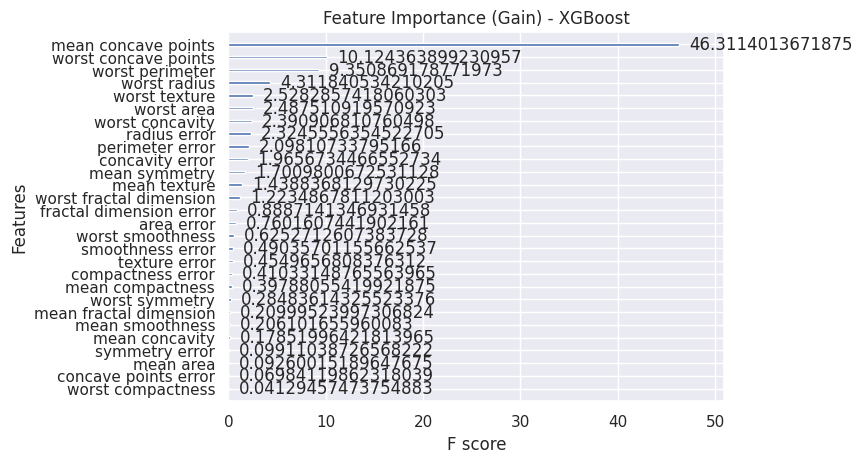

In [11]:
## some feature importance analysis
# Plot feature importance based on gain (default)


fig, ax = plt.subplots()
plot_importance(model, importance_type='gain', ax=ax)
ax.set_title("Feature Importance (Gain) - XGBoost")
ax.ticklabel_format(style='plain', axis='x', useOffset=False)  # To avoid scientific notation

# Format tick labels
for label in ax.get_xticklabels():
    label.set_text(f"{float(label.get_text()):.2f}")  # Adjust to 2 decimal places
plt.show()

In [12]:
features_for_ale = ['mean concave points', 'worst concave points', 'worst perimeter', 'worst radius', 'perimeter error', 'concavity error', 'mean symmetry']

## Partial Dependence Plots (PDP)

mean radius


/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


mean texture
mean perimeter


/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
mean fractal dimension
radius error
texture error
perimeter error
area error
smoothness error
compactness error
concavity error
concave points error
symmetry error
fractal dimension error
worst radius


/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/partial_dependence.py:1289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


worst texture
worst perimeter
worst area
worst smoothness
worst compactness
worst concavity
worst concave points
worst symmetry
worst fractal dimension


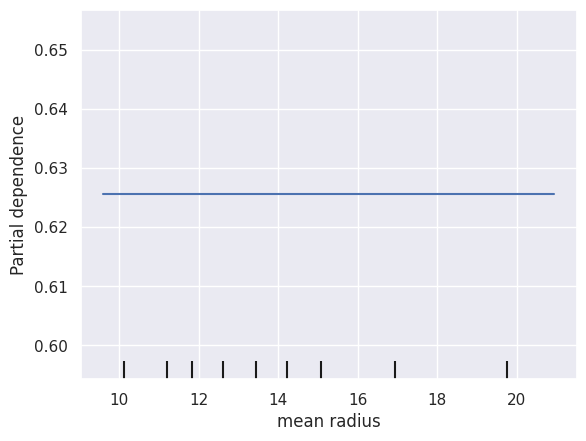

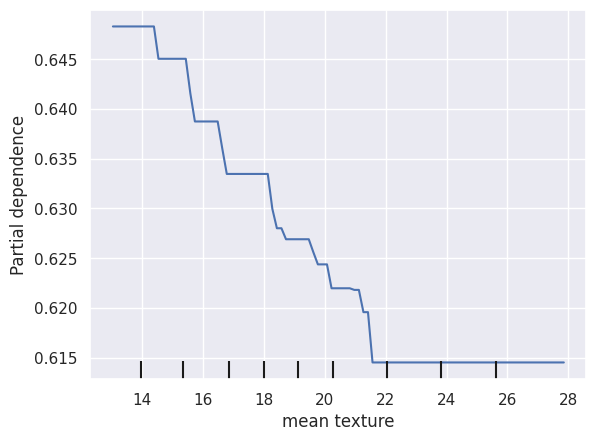

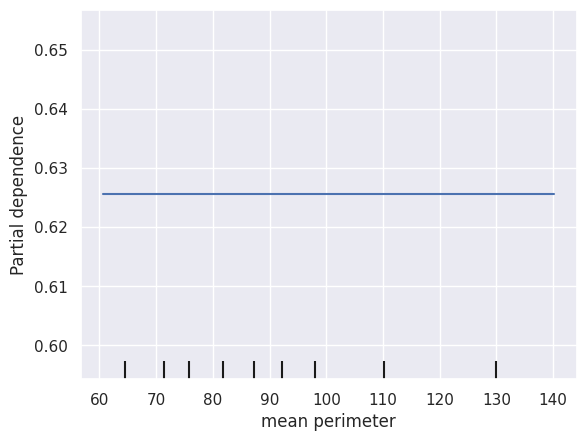

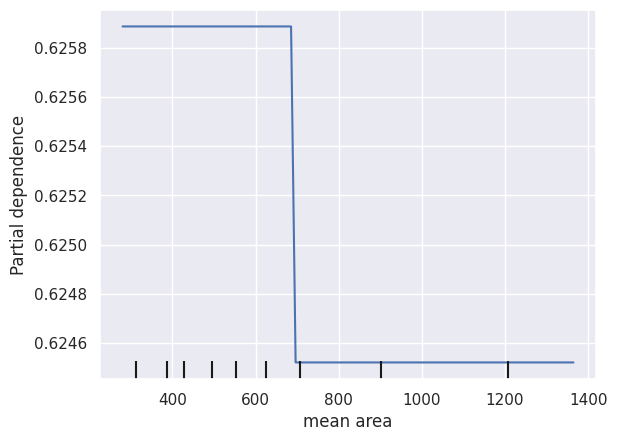

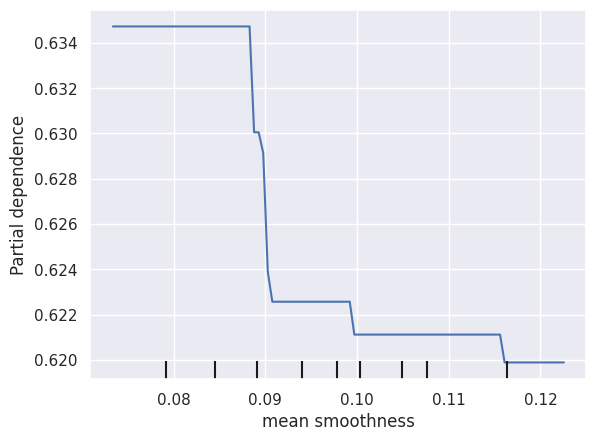

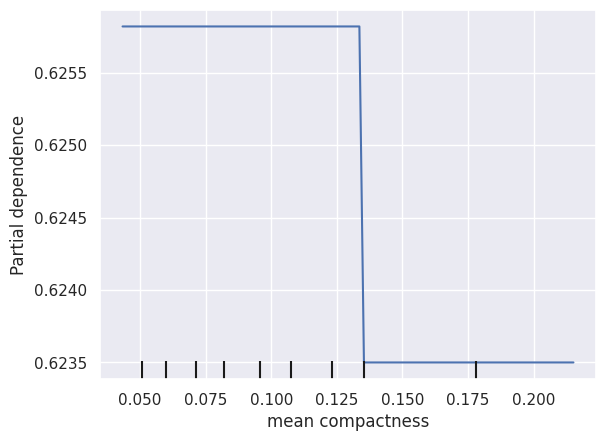

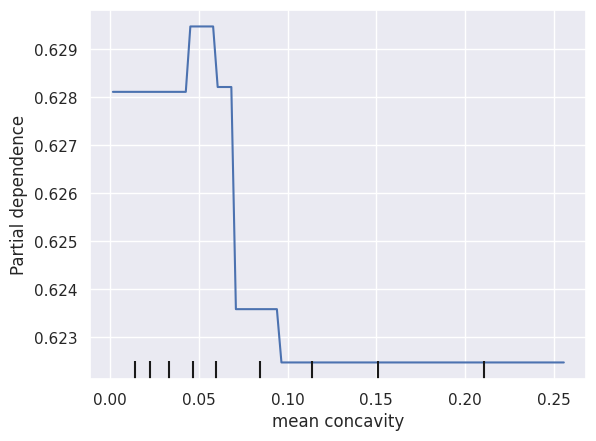

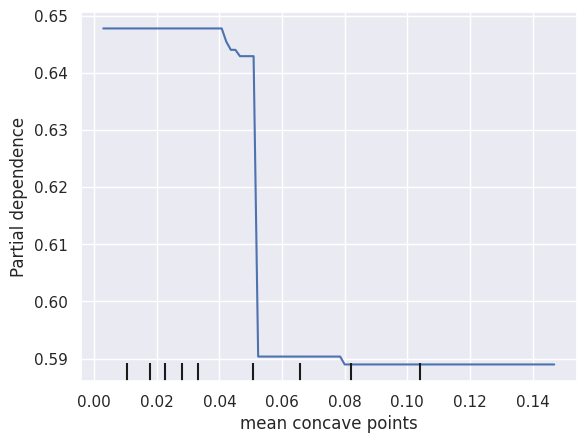

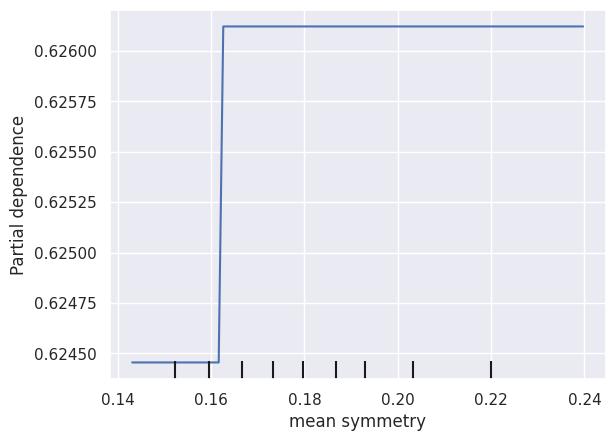

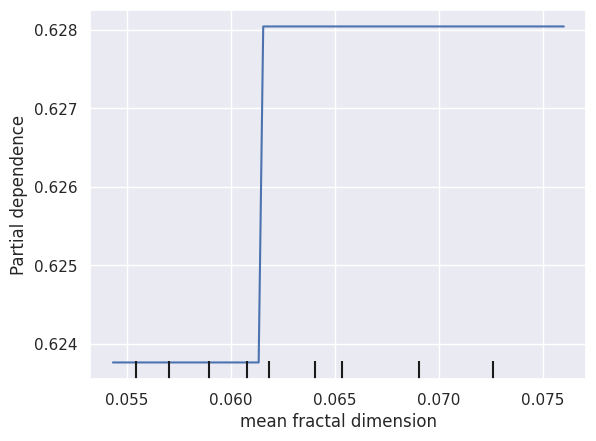

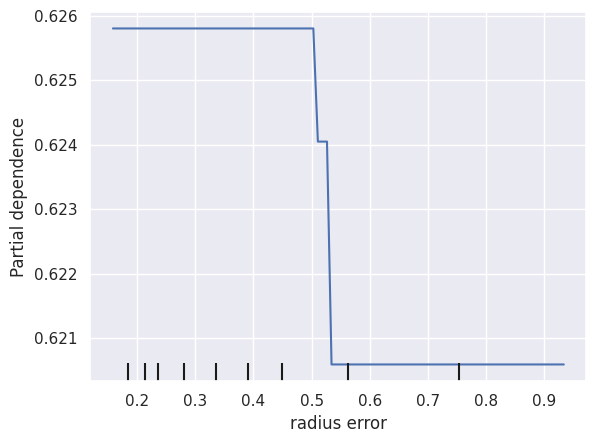

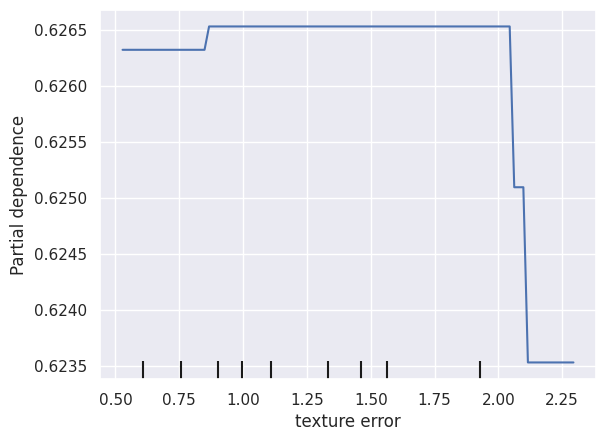

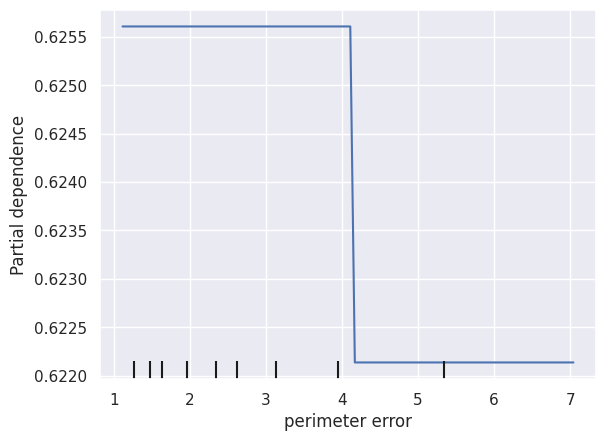

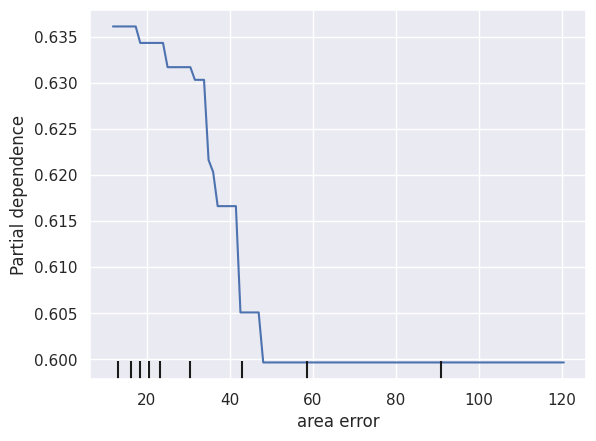

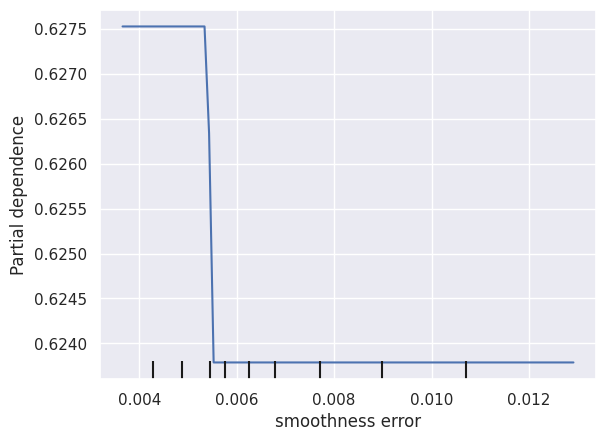

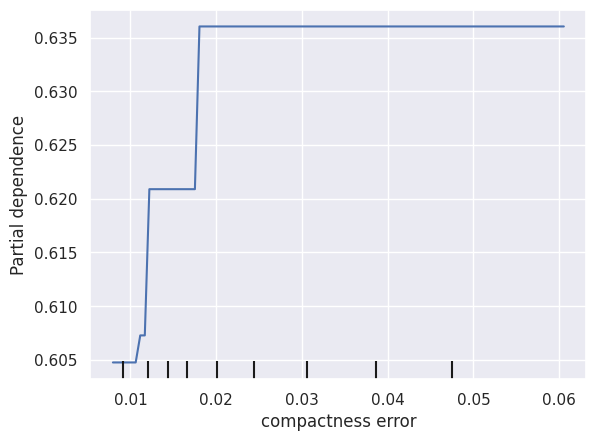

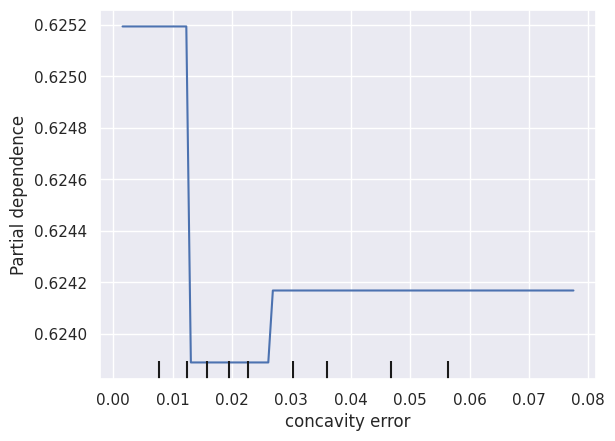

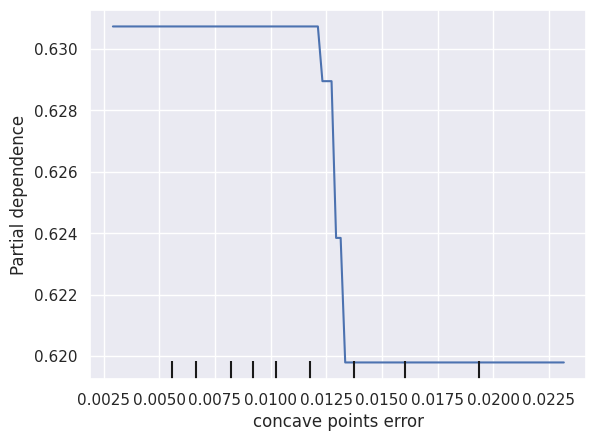

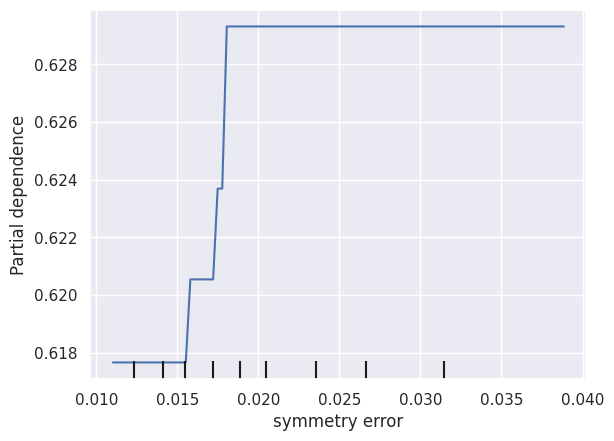

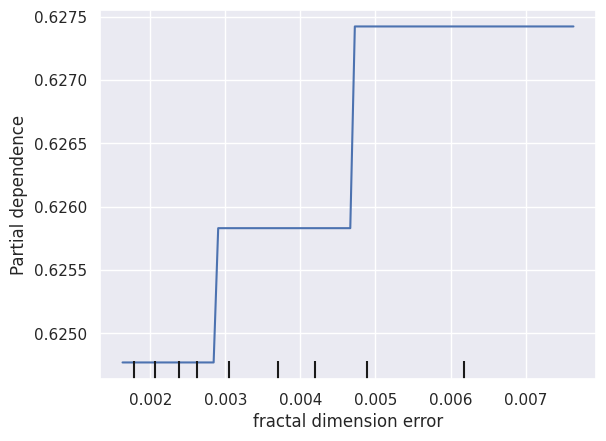

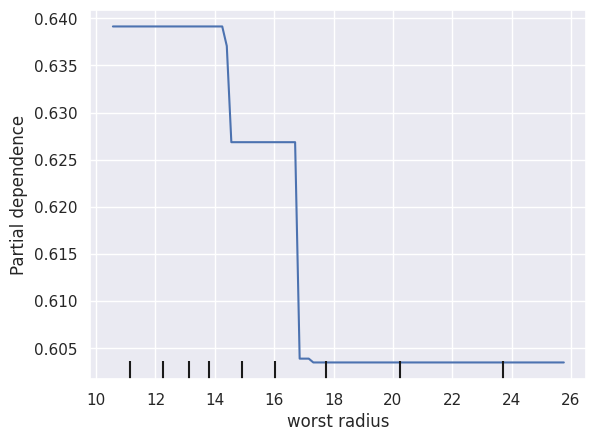

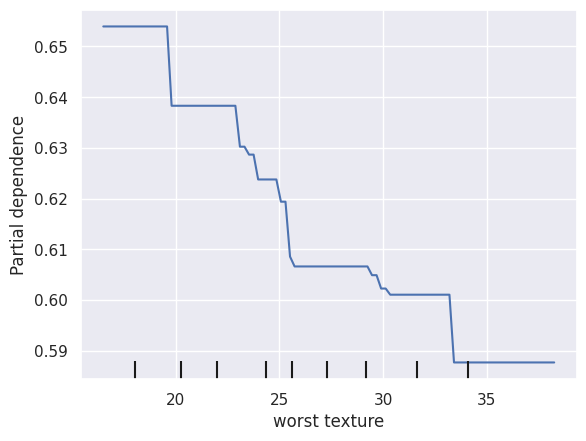

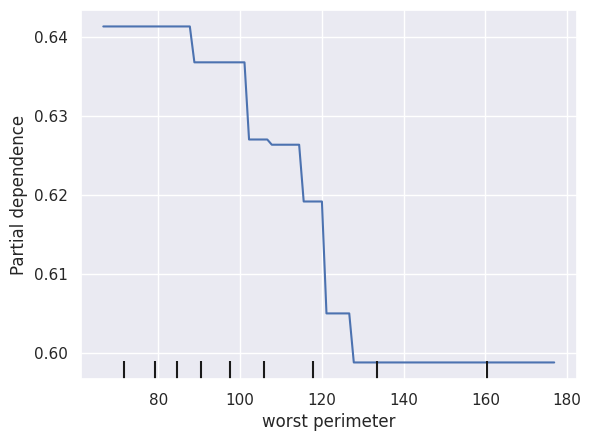

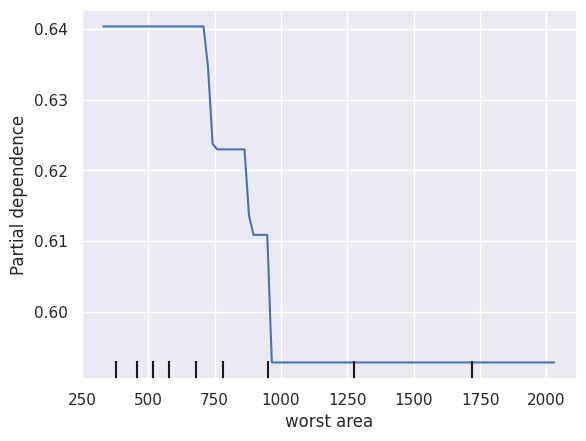

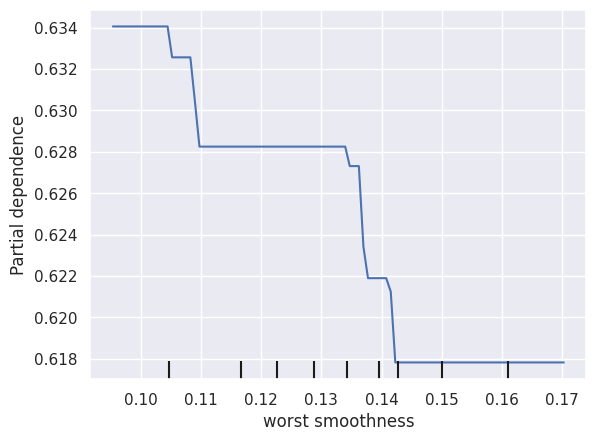

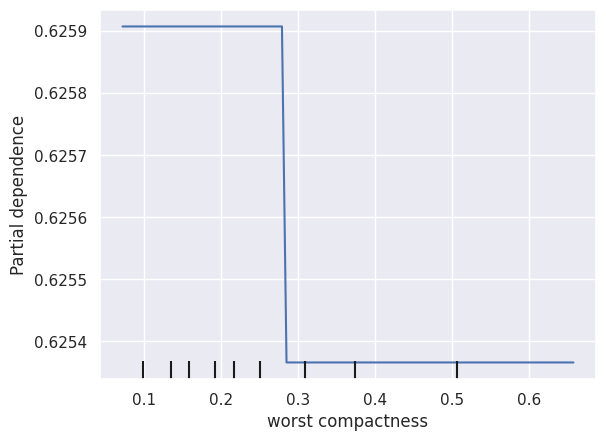

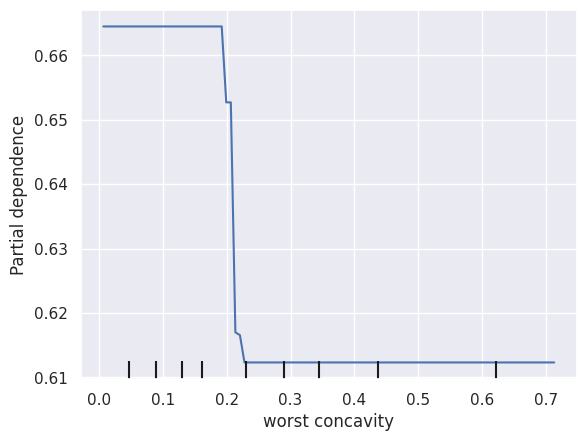

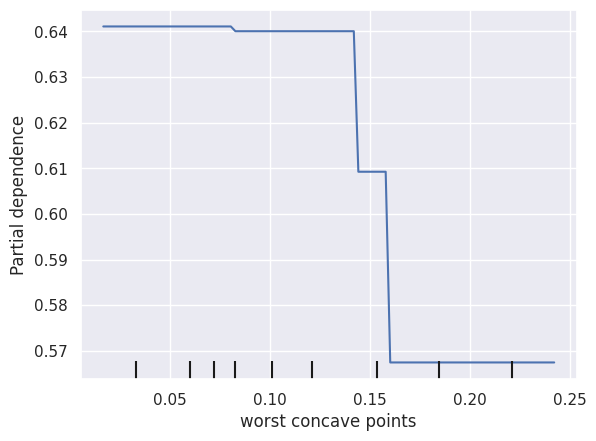

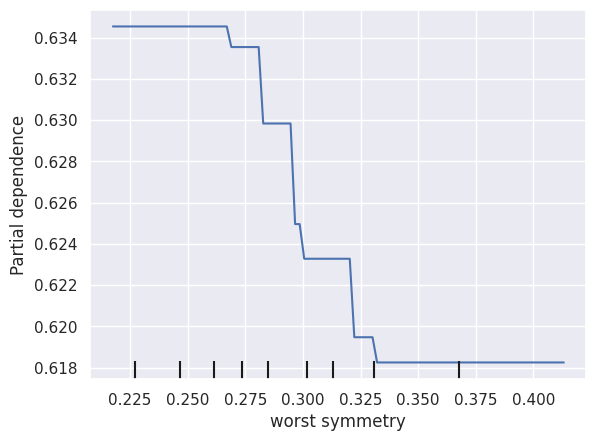

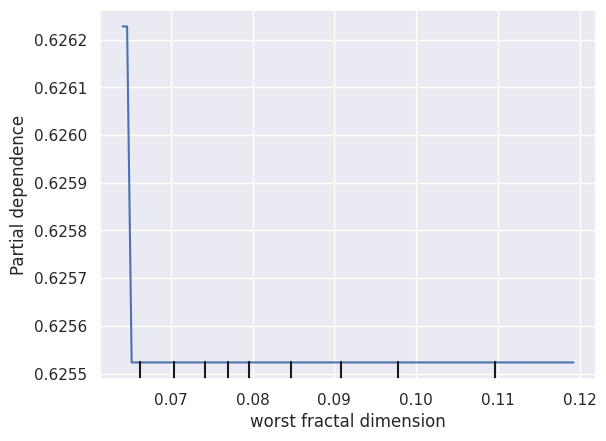

In [13]:
features = X_test.columns
for feature in features:
  print(feature)

  #  Use PartialDependenceDisplay to plot PDP
  PartialDependenceDisplay.from_estimator(model, X_test, [feature], kind='average') #kind='both'

## Partial Dependence Plots (PDP) Interpretation:

Need to reinterpret now that not scaling and have a better fit.

Some general points:
* Linear trends indicate a straightforward relationship, while non-linear trends suggest complex relationships or potential interactions with other features.

* Flat regions on PDPs show where changes in a feature have little to no effect on model predictions. For example, small texture values may not impact malignancy likelihood much, while very high values may.

* Sudden changes or thresholds may indicate a tipping point at which the model's classification strongly shifts toward malignancy or benignity, useful for identifying critical thresholds.

## ICE plots


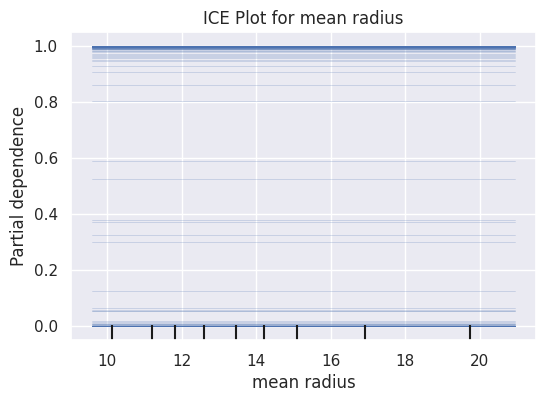

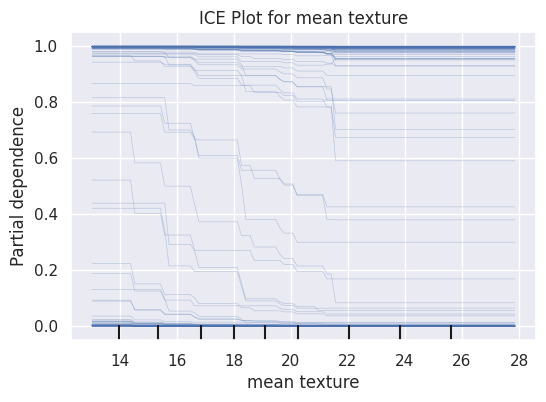

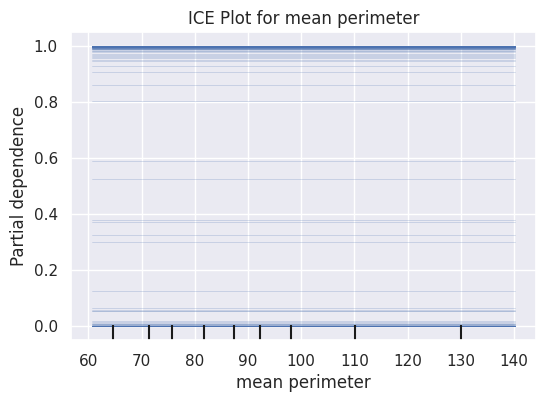

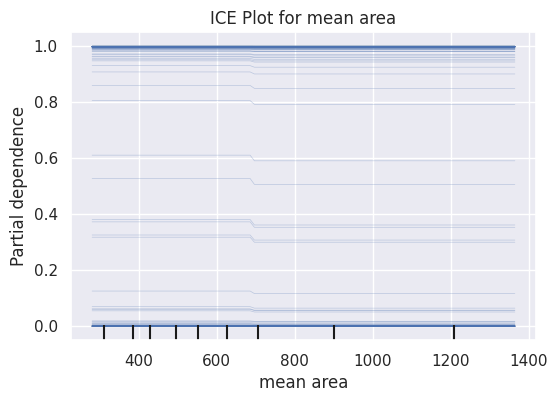

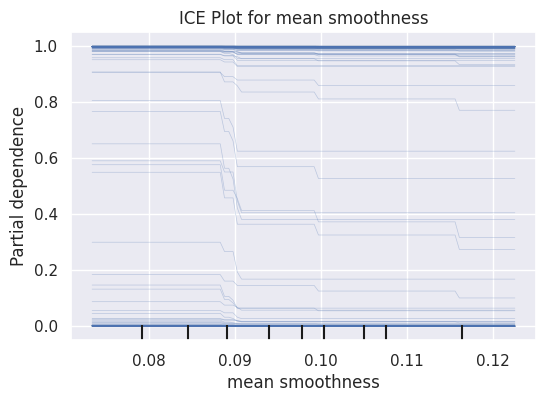

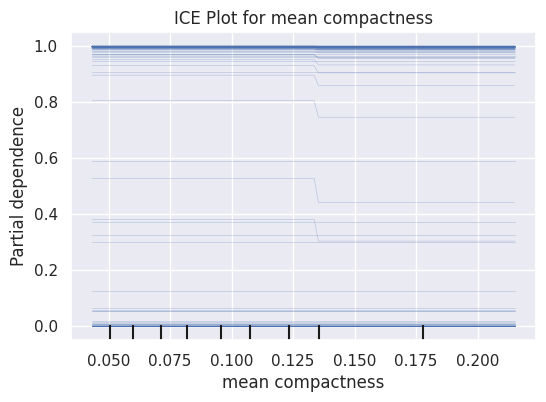

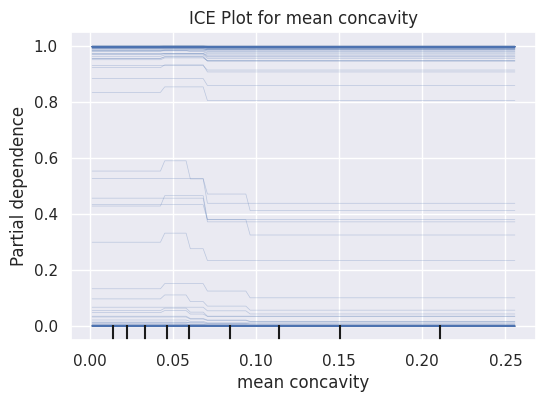

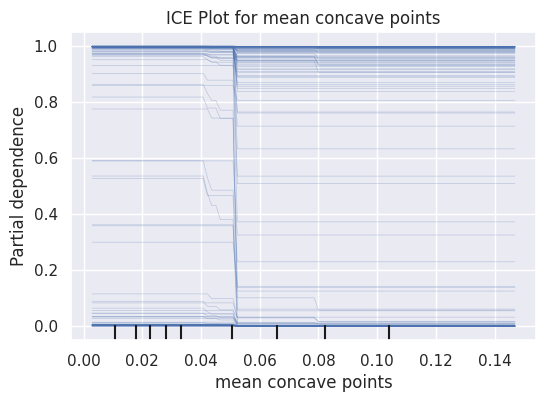

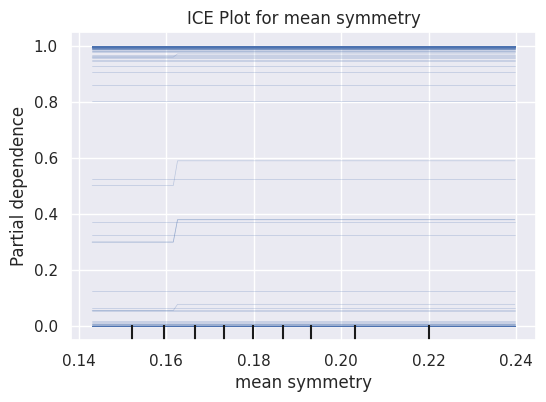

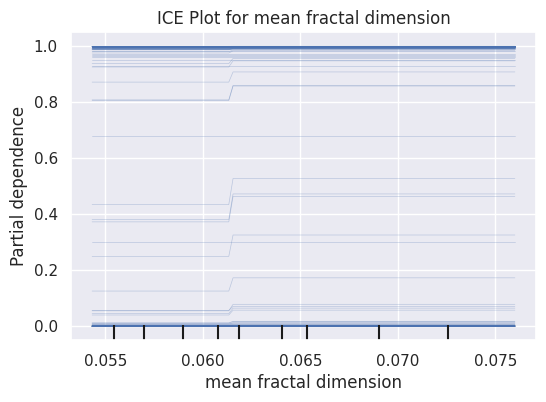

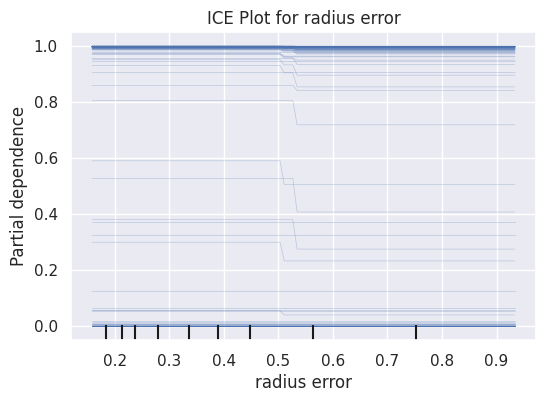

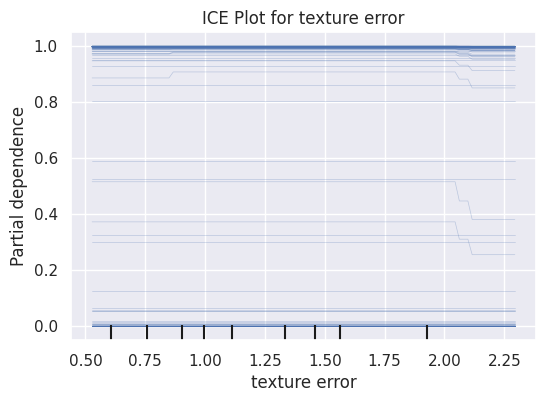

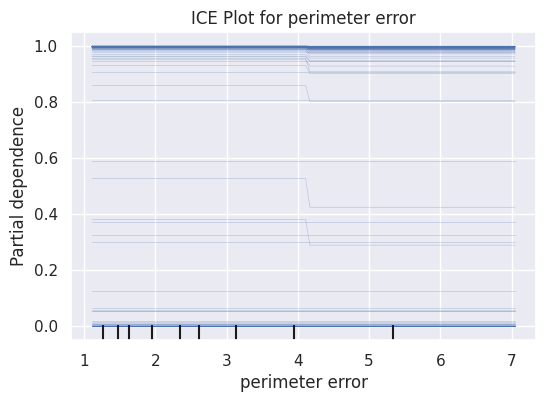

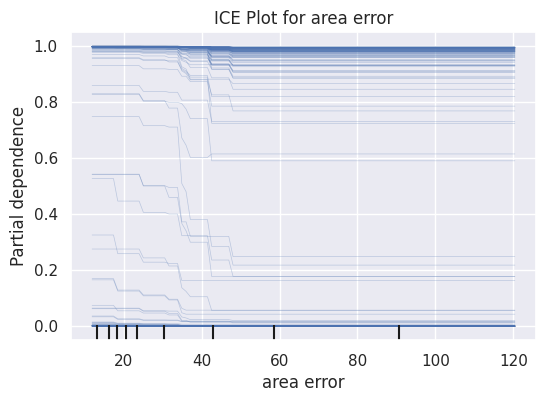

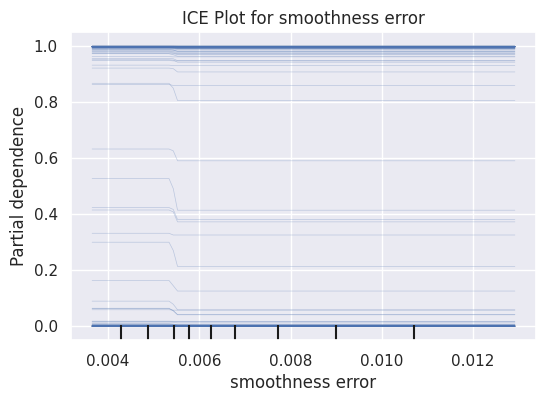

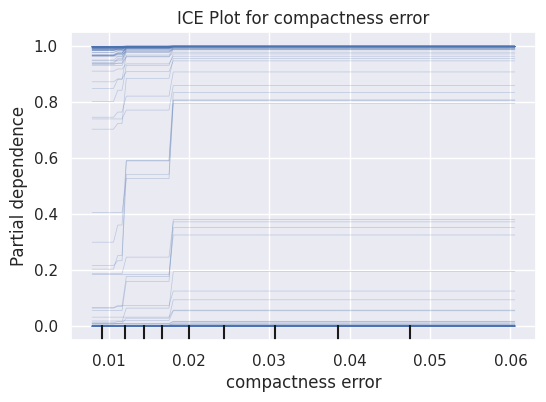

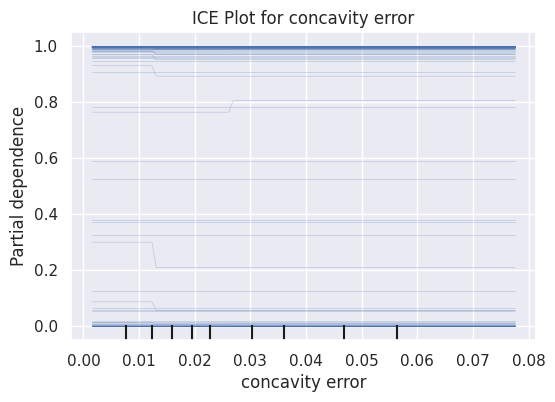

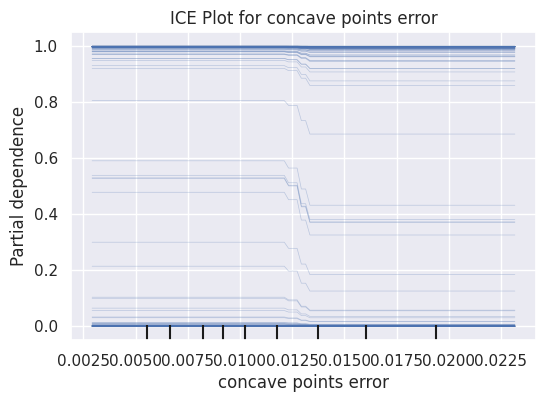

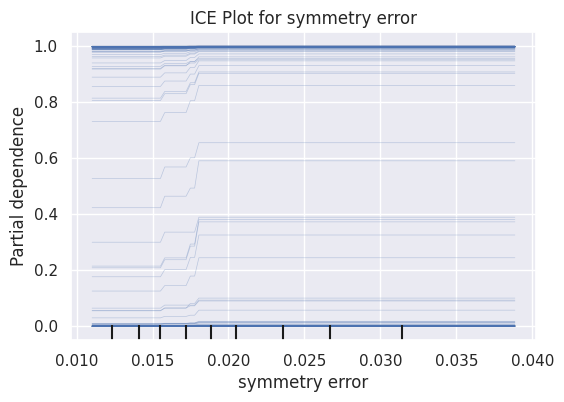

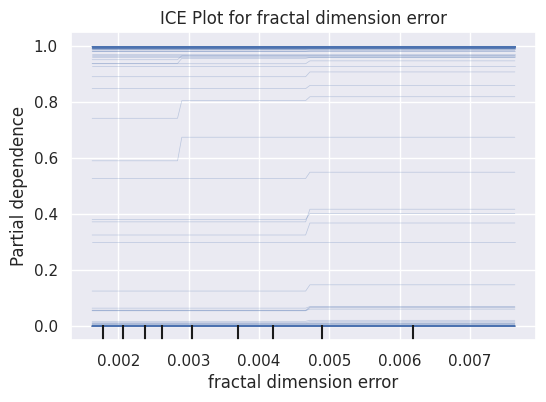

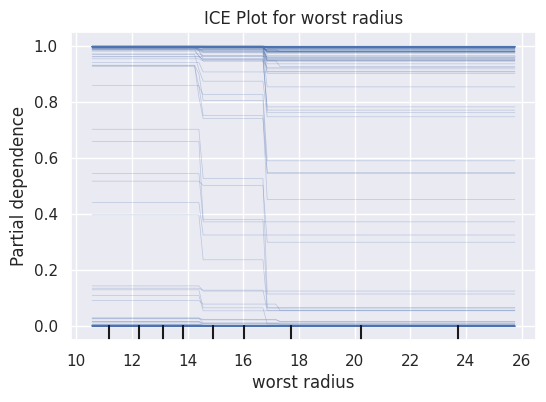

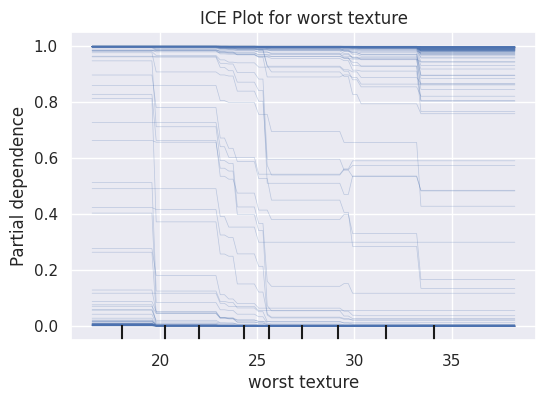

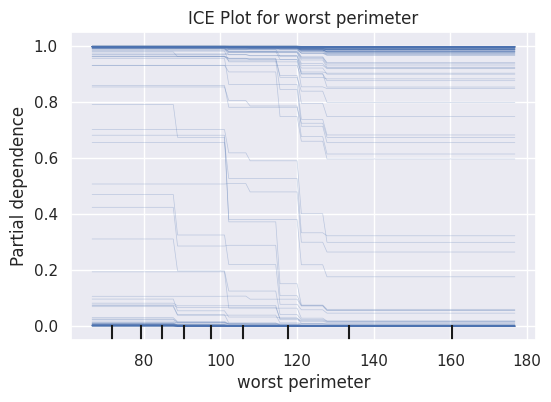

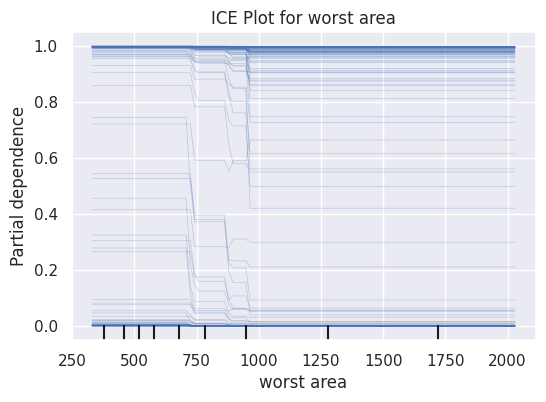

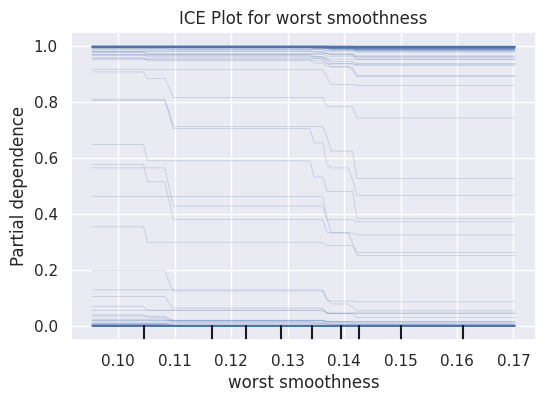

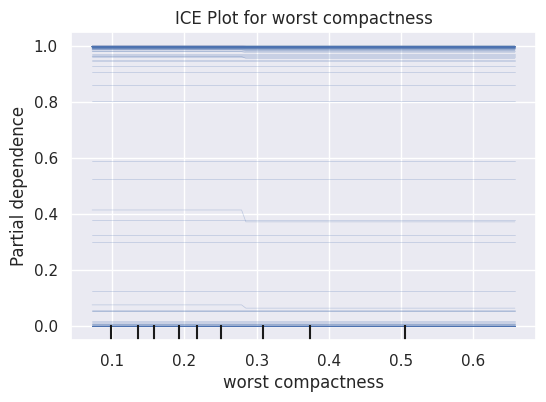

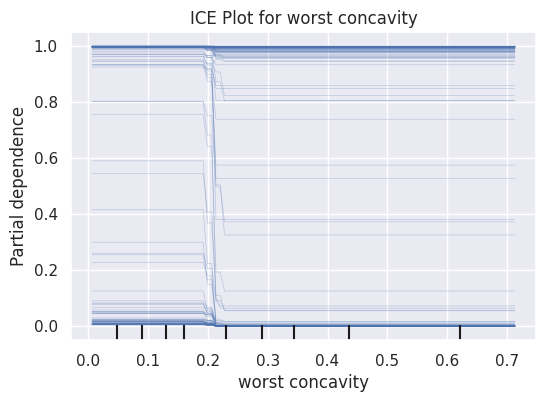

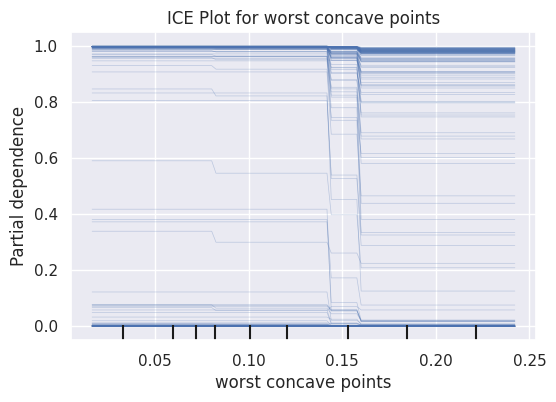

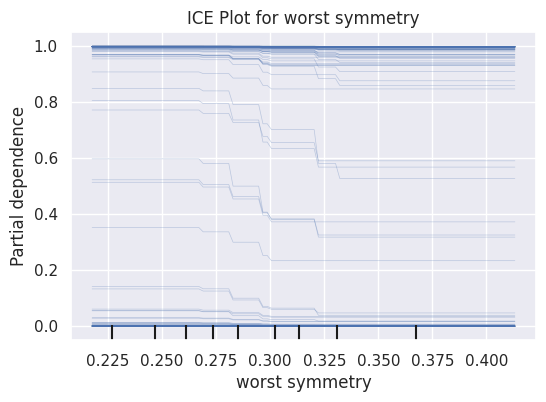

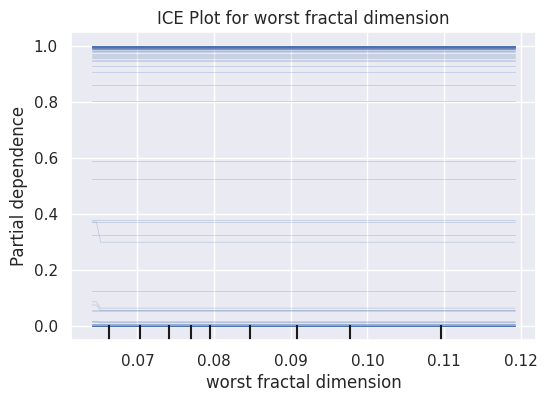

In [22]:
# Generate ICE plots for selected features

for feature_idx in features:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(model, X_test, [feature_idx], kind="individual", ax=ax)
    ax.set_title(f"ICE Plot for {feature_idx}")
    plt.show()

## ALE

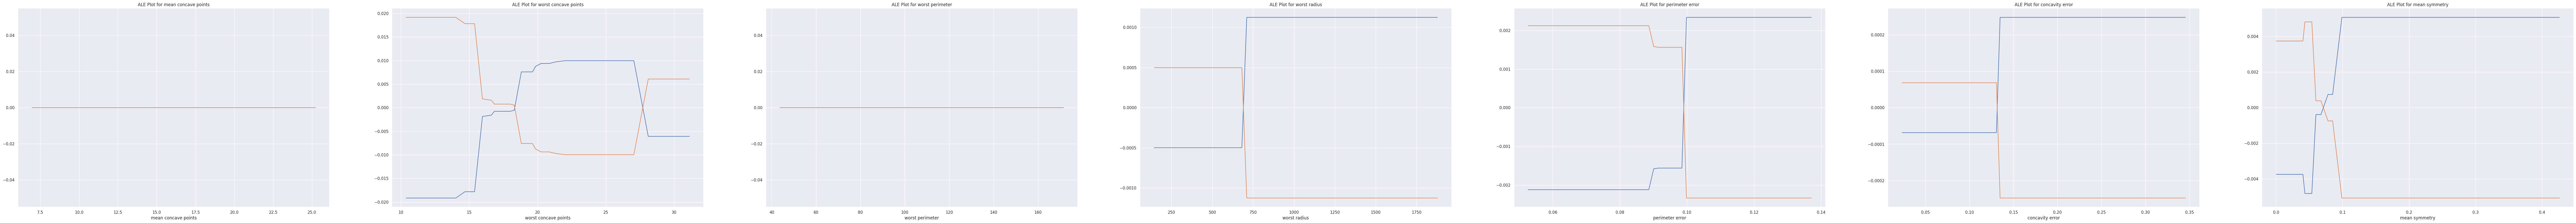

In [51]:
# Initialize ALE explainer
feature_names = features_for_ale
ale = ALE(model.predict_proba, feature_names=feature_names)

# Compute ALE for the selected features
ale_exp = ale.explain(X_test.values)

# Plot ALE for specific features: mean radius, mean texture, mean perimeter
selected_features = ['mean radius', 'mean texture', 'mean perimeter']
fig, axes = plt.subplots(1, len(feature_names), figsize=(128, 10))

for idx, feature in enumerate(feature_names):
    feature_index = feature_names.index(feature)
    axes[idx].plot(ale_exp.feature_values[feature_index], ale_exp.ale_values[feature_index])
    axes[idx].set_title(f"ALE Plot for {feature}")
    axes[idx].set_xlabel(feature)

In [ ]:
model_reduced = xgboost.XGBClassifier().fit(X_train_reduced_scaled, y_train)